#  Raster Operations in Python 
## 1. Introduction

This Jupyter notebook introduces and demonstrates advanced raster operations using the `rasterio` library. The content is based on selected sections of the book *Geocomputation with Python*, specifically focusing on spatial processing of raster data.

We will explore:

- **Raster padding and shifting** (Section 4.3.1)
- **Raster aggregation and disaggregation** (Section 4.3.2)
- **Resampling of raster datasets** (Section 4.3.3)
- **Raster-vector interactions** (Section 5):
  - Cropping and masking
  - Extracting raster values using points, lines and polygons
  - Rasterization of vector data
  - Vectorization of raster data (e.g., polygons and points)
- **Reprojecting raster datasets** (Section 6.8)

All operations are performed using the `rasterio`, `numpy`, and `geopandas` libraries, and will include code examples, diagrams and practical use cases commonly found in geospatial analysis workflows.


## 2. Setting the scene
### 2.1.  Importing libraries

In [718]:
import rasterio
import numpy as np
from rasterio.transform import from_origin
import rasterio.warp
import matplotlib.pyplot as plt
from rasterio.plot import show
import geopandas as gpd
import shapely
from rasterio.warp import reproject
from rasterio.enums import Resampling
import rasterio
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling
from rasterio.plot import show
import matplotlib.pyplot as plt
import os



### 2.2. Defining paths to datasets

In [721]:
m_root=r"/Users/macbook/Library/CloudStorage/OneDrive-UniversidadNacionaldeColombia/1_Periodos_Asignaturas/Cursos_2025_1/Programacion SIG/Talleres/Datos"
dem_path=m_root+"/dem_aoi.tif" # DEM

Print the DEM's affine transformation 

In [724]:
src = rasterio.open(dem_path)
transform=src.transform
print(transform) # Prints the affine transformations

| 0.00, 0.00,-73.20|
| 0.00,-0.00, 4.86|
| 0.00, 0.00, 1.00|


> From the previous output , can you tell ahich are the x and y coordinates of origin?
>
> Print them
> 
> Hint: Use `transform[index]` 

In [726]:
#Write your code here


## 3. Extent and origin
### 3.1 Padding an image

Sometimes we pad a raster to facilitate edge processing (e.g. focal filters). Padding can be done using `np.pad`, and you must update the affine transform accordingly.


In [728]:
# Read the values of the first band of the raster into a NumPy array.
r = src.read(1)

# Define the number of rows (top and bottom) and columns (left and right) to add as padding.
rows, cols = 1, 2

# Pad the array 'r' with 1 extra row on top and bottom, and 2 extra columns on the left and right.
# The value used for padding is 0. This results in a larger array with a border of 18s.
r_pad = np.pad(r, ((rows, rows), (cols, cols)), constant_values=0)


# Extract the original top-left x and y coordinates (origin) from the raster's affine transform.
xmin, ymax = src.transform[2], src.transform[5]

# Extract the pixel size in the x and y directions (resolution).
dx, dy = src.transform[0], src.transform[4]

# Calculate the new top-left x and y coordinates after padding.
# Since we added columns on the left, shift the origin to the west (xmin decreases).
# Since we added rows on the top, shift the origin to the north (ymax increases),
# but dy is negative (since rasters are typically top-down), so we subtract dy * rows.
xmin_new = xmin - dx * cols
ymax_new = ymax - dy * rows

# Create a new affine transformation using the updated origin and the original pixel size.
# Note that abs(dy) is used to ensure the y-pixel size remains positive.
new_transform = rasterio.transform.from_origin(
    west=xmin_new, 
    north=ymax_new, 
    xsize=dx, 
    ysize=abs(dy)
)
new_transform

Affine(0.0002694945852358564, 0.0, -73.19862627616328,
       0.0, -0.0002694945852358564, 4.855617868757481)

### 3.1. Visualisation of padded raster

<Axes: >

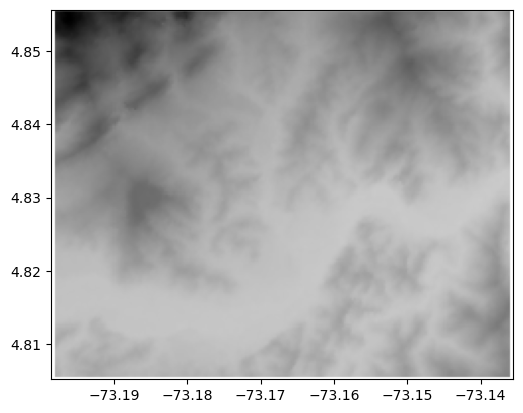

In [730]:
fig, ax = plt.subplots()
show(r_pad, transform=new_transform, ax=ax, cmap="Greys")

### 3.2. Shifting a Raster

In raster processing, sometimes we need to shift the spatial position of a raster without modifying its pixel values or resolution. This can be done by adjusting the raster’s origin via its affine transformation matrix.

Such a shift may be needed:

* To align layers manually

* To simulate displacements

* Or to understand how origin affects raster alignment and overlay

In the following example, we shift the origin of the raster slightly: 0.25 units to the left and 0.25 units upward. Note that no pixel values are changed — only the raster’s placement on the spatial grid is altered.



In [732]:
# Shift the origin by 0.25 units west (left) and 0.25 units north (up)
xmin_shift = xmin - 0.0025  # Move the left edge 0.25 units westward
ymax_shift = ymax + 0.0025  # Move the top edge 0.25 units upward


# Create a new affine transform based on the shifted origin
# This transform keeps the same pixel size (dx, dy) but adjusts the starting corner
shifted_transform = from_origin(xmin_shift, ymax_shift, dx, abs(dy))

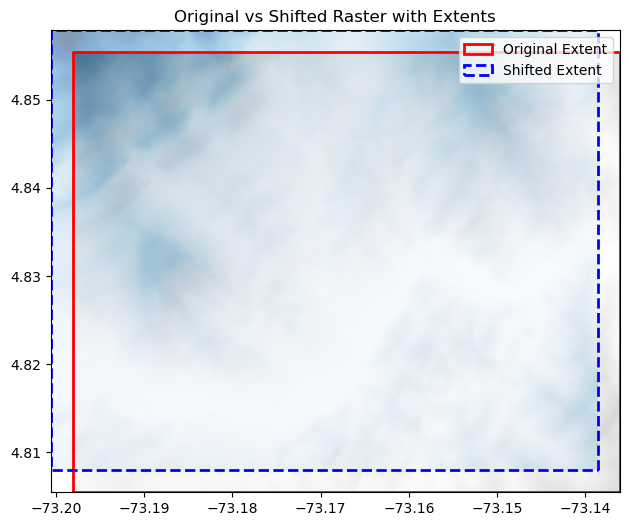

In [733]:
import matplotlib.pyplot as plt
from rasterio.plot import show
import geopandas as gpd
import shapely.geometry as geom
from matplotlib.patches import Patch

# Original raster data and shape
r = src.read(1)
rows, cols = r.shape

# Create bounding boxes
orig_bbox_geom = geom.box(*src.bounds)
shifted_bounds = rasterio.transform.array_bounds(rows, cols, shifted_transform)
shifted_bbox_geom = geom.box(*shifted_bounds)

# Convert to GeoSeries for easy plotting
orig_bbox = gpd.GeoSeries([orig_bbox_geom])
shifted_bbox = gpd.GeoSeries([shifted_bbox_geom])

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Original raster
show(r, transform=src.transform, ax=ax, cmap="Greys", alpha=0.5)

# Shifted raster
show(r, transform=shifted_transform, ax=ax, cmap="Blues", alpha=0.5)

# Bounding boxes
orig_bbox.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
shifted_bbox.plot(ax=ax, facecolor='none', edgecolor='blue', linestyle='--', linewidth=2)

# Manual legend using patches
legend_elements = [
    Patch(facecolor='none', edgecolor='red', label='Original Extent', linewidth=2),
    Patch(facecolor='none', edgecolor='blue', linestyle='--', label='Shifted Extent', linewidth=2)
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_title("Original vs Shifted Raster with Extents")
plt.show()


## 4. Aggregation and Disaggregation

- **Aggregation**: Reduce resolution (fewer, larger cells)
- **Disaggregation**: Increase resolution (more, smaller cells)
### 4.1. Aggregation


Aggregation refers to the process of reducing the spatial resolution of a raster dataset by combining multiple neighbouring pixels into fewer, larger pixels. This is often done to reduce file size, speed up processing, or harmonise the resolution of datasets before further analysis.

In this example, we reduce the resolution of the input DEM raster by a factor of 5 (i.e., to 20% of its original number of rows and columns). This means each new cell represents an area previously covered by a 5x5 block of the original raster.

We use the `Resampling.average` method, which computes the **mean** value of all the input cells that fall within each new aggregated cell. This method is appropriate for continuous raster data such as elevation, where averaging makes sense.


In [736]:
# Set aggregation factor to reduce raster resolution
factor = 0.2

# Read raster values into a new shape scaled by the aggregation factor
# Resampling method 'average' takes the mean of input cells
r_agg = src.read(1, out_shape=(int(src.height * factor), int(src.width * factor)),
    resampling=rasterio.enums.Resampling.average)

# Calculate the new affine transform for the aggregated raster
agg_transform = src.transform * src.transform.scale(
    (src.width / r_agg.shape[1]),
    (src.height / r_agg.shape[0]))

#### 4.1.1. Visualisation

Text(0.5, 1.0, 'Aggregated Raster (Average)')

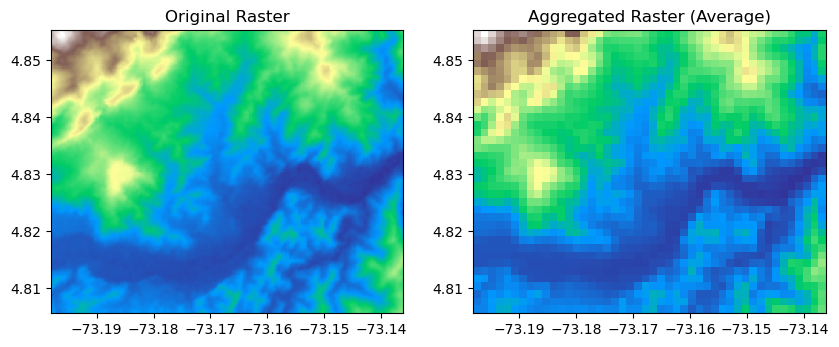

In [738]:
# Plot original and aggregated rasters side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
show(src.read(1), transform=src.transform, ax=ax1, cmap="terrain")
ax1.set_title("Original Raster")
show(r_agg, transform=agg_transform, ax=ax2, cmap="terrain")
ax2.set_title("Aggregated Raster (Average)")

### 4.2. Disaggregation
is the process of increasing the spatial resolution of a raster by generating more, smaller pixels. This can be useful when harmonising datasets with finer resolutions or when improving visual interpretation.

In the following example, we disaggregate the input DEM raster by a factor of 5, which means the number of rows and columns will each increase fivefold. As a result, the new raster will have 25 times more pixels than the original.

We use the `Resampling.bilinear` method, which applies **bilinear interpolation**. This method calculates each new pixel value as a weighted average of the four nearest original pixels. It is suitable for continuous data such as elevation, as it produces a smooth gradient between values.

The raster is read into a larger shape (`out_shape`), and we update the affine transformation to reflect the increased spatial resolution.


In [743]:
# Set disaggregation factor to increase raster resolution
factor = 5

# Read raster into a larger shape, using bilinear interpolation for smoothing
r_disagg = src.read(1, out_shape=(int(src.height * factor), int(src.width * factor)),
    resampling=rasterio.enums.Resampling.bilinear)

# Update the transform to reflect the disaggregated resolution
disagg_transform = src.transform * src.transform.scale(
    (src.width / r_disagg.shape[1]),
    (src.height / r_disagg.shape[0]))



#### 4.2.1. Visualisation

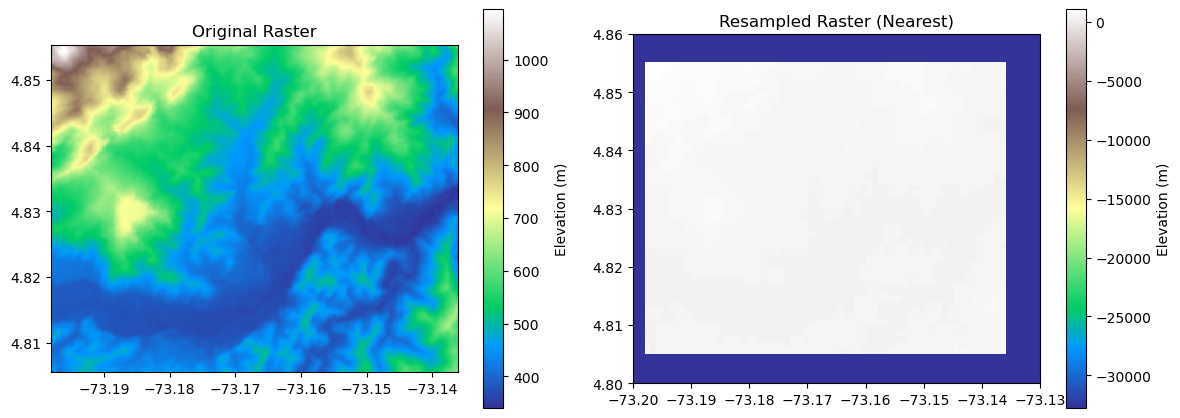

In [745]:
# Reopen in read mode for visualisation
with rasterio.open(resample_raster_path) as resampled:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot original raster with colourbar
    im1 = show(src.read(1), transform=src.transform, ax=ax1, cmap="terrain")
    ax1.set_title("Original Raster")
    cbar1 = plt.colorbar(im1.get_images()[0], ax=ax1, orientation='vertical', shrink=0.7)
    cbar1.set_label("Elevation (m)")

    # Plot resampled raster with colourbar
    im2 = show(resampled.read(1), transform=resampled.transform, ax=ax2, cmap="terrain")
    ax2.set_title("Resampled Raster (Nearest)")
    cbar2 = plt.colorbar(im2.get_images()[0], ax=ax2, orientation='vertical', shrink=0.7)
    cbar2.set_label("Elevation (m)")

    plt.tight_layout()
    plt.show()


## 5. Resampling 
In some cases, we need to transform a raster to match a new spatial grid that differs in extent and resolution. This process is known as **resampling**. Unlike aggregation or disaggregation which rely on fixed scale factors, resampling allows for complete control over the destination grid.

Resampling involves computing new pixel values for a raster that has been aligned to a new coordinate system or grid. It is useful when matching rasters with different resolutions or aligning them to a predefined template.

Several resampling methods exist, each appropriate for different data types:
- nearest: copies the value of the nearest pixel (good for categorical data)
- bilinear: performs weighted averaging using four neighbours (good for continuous data)
- average, max, min, mode, etc. — useful for summarising blocks of values

We use `rasterio.warp.reproject()` for resampling to arbitrary grids.



### 5.1. Defining the target grid
Before performing a raster resampling operation, we must define the target grid. This grid specifies the spatial extent and the resolution to which the original raster will be resampled. The extent includes the bounding box (minimum and maximum coordinates in both x and y directions), and the resolution sets the pixel size (width and height in coordinate units).

In this example, we define a new target grid in WGS84 coordinate reference system. The bounding box covers a small region in Colombia (longitude from -73.2 to -73.13 and latitude from 4.8 to 4.86), and we use a resolution of `0.020` degrees.


In [750]:
### Define target grid:
from rasterio.transform import from_origin

# Set bounding box coordinates in WGS84 and desired resolution (in degrees)
xmin, xmax = -73.2, -73.13
ymin, ymax = 4.8, 4.86
res = 0.001  # 

# Create affine transform for the target grid
resample_transform = from_origin(xmin, ymax, res, res)

# Calculate output raster dimensions based on extent and resolution
width = int((xmax - xmin) / res)
height = int((ymax - ymin) / res)


### 5.2. Creating and Writing the Resampled Raster uusing the nearest Neighbour method

Once the target grid has been defined, the next step is to resample the original raster and write it to a new file. This involves two main actions:

1. **Preparing the Output File:** We begin by copying the metadata of the source raster and updating it with the new spatial dimensions  and transformation transform. This ensures that the output raster inherits essential properties like CRS and data type.

2. **Performing the Resampling Operation:** Using the `rasterio.warp.reproject()` function, we project the data from the source raster into the new grid using the nearest neighbour resampling method. This method assigns each output pixel the value of the closest input pixel, making it ideal for categorical or discrete data (e.g., land cover classes).

The result is a new GeoTIFF file containing the resampled raster aligned to the defined target grid.

In [752]:
### Create output file
resample_raster_path=m_root+"/dem_resample_nearest.tif"

# Copy source raster metadata and update with new transform and dimensions
dst_kwargs = src.meta.copy()
dst_kwargs.update({
                    "transform": resample_transform,
                    "width": width, 
                    "height": height})

# Open a new file to write the resampled raster
dst = rasterio.open(resample_raster_path, "w", **dst_kwargs)

### Resample with nearest neighbour (write and visualise)

# Perform the resampling and write to file
rasterio.warp.reproject(
    source=rasterio.band(src, 1),
    destination=rasterio.band(dst, 1),
    src_transform=src.transform,
    src_crs=src.crs,
    dst_transform=resample_transform,
    dst_crs=src.crs,
    resampling=rasterio.enums.Resampling.nearest

)

# Close the file to finalise writing
dst.close()


### 5.3.Another Resampling Example: Nearest Neighbour

The following block demonstrates how to perform **nearest neighbour** resampling using the same method and structure as other `rasterio.warp.reproject()` calls. It mirrors the example used for maximum resampling but applies the `nearest` method instead.

This approach is useful when you want to clearly isolate the resampling logic and reuse consistent grid definitions (transform and metadata). Note that the only difference from the `max` method is the `resampling` argument.
This pattern can be reused for other resampling types (e.g. `average`, `max`, `min`, `mode`) by simply adjusting the `resampling=` argument. Ensure the metadata and grid remain consistent when comparing results visually.




In [755]:
# Create output path for nearest neighbour result
resample_nearest_path =m_root+ "/dem_resample_nearest.tif"

# Open a new file for writing resampled data
dst = rasterio.open(resample_nearest_path, 'w', **dst_kwargs)

# Perform resampling using nearest neighbour
rasterio.warp.reproject(
    source=rasterio.band(src, 1),
    destination=rasterio.band(dst, 1),
    src_transform=src.transform,
    src_crs=src.crs,
    dst_transform=resample_transform,
    dst_crs=src.crs,
    resampling=rasterio.enums.Resampling.nearest
)

# Finalise output file
dst.close()

### 5.4 Another Resampling Example: Maximum value


In [758]:

# Define the path for the maximum resampled raster
resample_max_path =m_root+ "/dem_resample_max.tif"


# Open a new file to store the result
dst = rasterio.open(resample_max_path, 'w', **dst_kwargs)

# Perform resampling using nearest neighbour
rasterio.warp.reproject(
    source=rasterio.band(src, 1),
    destination=rasterio.band(dst, 1),
    src_transform=src.transform,
    src_crs=src.crs,
    dst_transform=resample_transform,
    dst_crs=src.crs,
    resampling=rasterio.enums.Resampling.max
)
# Finalise output file
dst.close()

#### Visualisation

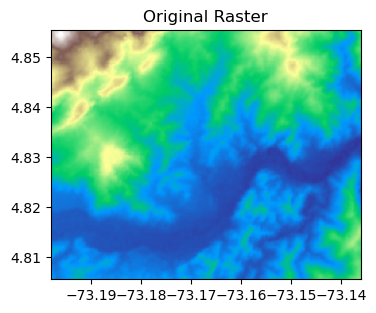

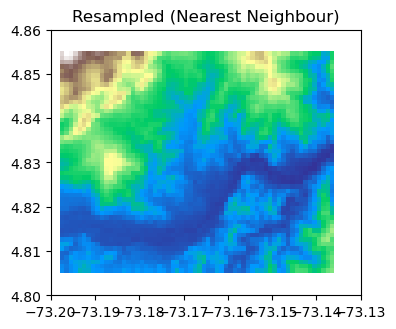

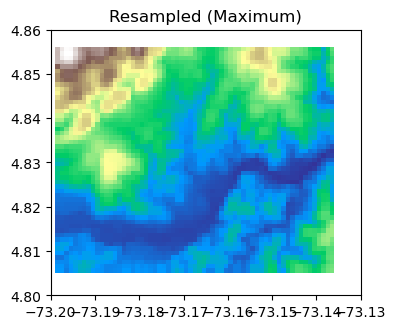

In [760]:
# Compare input raster with nearest neighbour and maximum resampled versions
import matplotlib.pyplot as plt
from rasterio.plot import show

# Input raster
fig, ax = plt.subplots(figsize=(4, 4))
show(src, ax=ax, cmap="terrain")
ax.set_title("Original Raster")

# Nearest neighbour resampling result
fig, ax = plt.subplots(figsize=(4, 4))
with rasterio.open(resample_nearest_path) as src_nn:
    show(src_nn, ax=ax, cmap="terrain")
    ax.set_title("Resampled (Nearest Neighbour)")

# Maximum resampling result
fig, ax = plt.subplots(figsize=(4, 4))
with rasterio.open(resample_max_path) as src_max:
    show(src_max, ax=ax, cmap="terrain")
    ax.set_title("Resampled (Maximum)")


## 6. Reprojecting
The folowing chunks demonstrate how to reproject a raster from WGS84 to EPSG:9377
using rasterio.warp.calculate_default_transform and rasterio.warp.reproject.




In [802]:
# Define the destination CRS (EPSG:9377)
dst_crs = "EPSG:9377"


# Calculate transformation matrix and new dimensions for the target CRS
dst_transform, dst_width, dst_height = rasterio.warp.calculate_default_transform(
    src.crs,
    dst_crs,
    src.width,
    src.height,
    *src.bounds
)
print(dst_transform)
print(dst_width)
print( dst_height)

# Copy source metadata and update CRS, transform, width, and height
dst_kwargs = src.meta.copy()
dst_kwargs.update({
    "crs": dst_crs,
    "transform": dst_transform,
    "width": dst_width,
    "height": dst_height
})
dst_kwargs


| 29.83, 0.00, 4978043.56|
| 0.00,-29.83, 2094512.75|
| 0.00, 0.00, 1.00|
230
185


{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -32768.0,
 'width': 230,
 'height': 185,
 'count': 1,
 'crs': 'EPSG:9377',
 'transform': Affine(29.833953327833513, 0.0, 4978043.556500151,
        0.0, -29.833953327833513, 2094512.749186477)}

### 6.1. 

In [781]:
# Create output file for reprojected raster
dem_9377_path = m_root+"/dem_9377.tif"
dem_src_9377 = rasterio.open(dem_9377_path , 'w', **dst_kwargs)

rasterio.warp.reproject(
    source=rasterio.band(src, 1),
    destination=rasterio.band(dem_src_9377 , 1),
    src_transform=src.transform,
    src_crs=src.crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    resampling=rasterio.enums.Resampling.nearest
)
dem_src_9377.meta
dem_src_9377.close()

Examining the unique raster values tells us that the new raster has the same categories.

In [798]:
dem_src_9377 = rasterio.open(dem_9377_path)
print(dem_src_9377.meta)
print(np.unique(dem_src_9377.read(1)))


{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 230, 'height': 185, 'count': 1, 'crs': CRS.from_epsg(9377), 'transform': Affine(29.833953327833513, 0.0, 4978043.556500151,
       0.0, -29.833953327833513, 2094512.749186477)}
[ 340  341  342  343  344  345  346  347  348  349  350  351  352  353
  354  355  356  357  358  359  360  361  362  363  364  365  366  367
  368  369  370  371  372  373  374  375  376  377  378  379  380  381
  382  383  384  385  386  387  388  389  390  391  392  393  394  395
  396  397  398  399  400  401  402  403  404  405  406  407  408  409
  410  411  412  413  414  415  416  417  418  419  420  421  422  423
  424  425  426  427  428  429  430  431  432  433  434  435  436  437
  438  439  440  441  442  443  444  445  446  447  448  449  450  451
  452  453  454  455  456  457  458  459  460  461  462  463  464  465
  466  467  468  469  470  471  472  473  474  475  476  477  478  479
  480  481  482  483  484  485  486  487  488 

In [792]:
print(src.meta)
print(np.unique(src.read(1)))

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 230, 'height': 185, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002694945852358564, 0.0, -73.19808728699282,
       0.0, -0.0002694945852358564, 4.8553483741722445)}
[ 340  341  342  343  344  345  346  347  348  349  350  351  352  353
  354  355  356  357  358  359  360  361  362  363  364  365  366  367
  368  369  370  371  372  373  374  375  376  377  378  379  380  381
  382  383  384  385  386  387  388  389  390  391  392  393  394  395
  396  397  398  399  400  401  402  403  404  405  406  407  408  409
  410  411  412  413  414  415  416  417  418  419  420  421  422  423
  424  425  426  427  428  429  430  431  432  433  434  435  436  437
  438  439  440  441  442  443  444  445  446  447  448  449  450  451
  452  453  454  455  456  457  458  459  460  461  462  463  464  465
  466  467  468  469  470  471  472  473  474  475  476  477  478  479
  480  481  482  483  484  485  486  4

Examining the unique raster values tells us that the new raster has the same categories, plus the value 255 representing ‘No Data’:

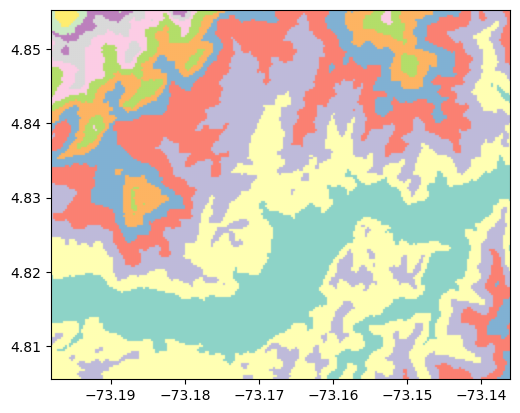

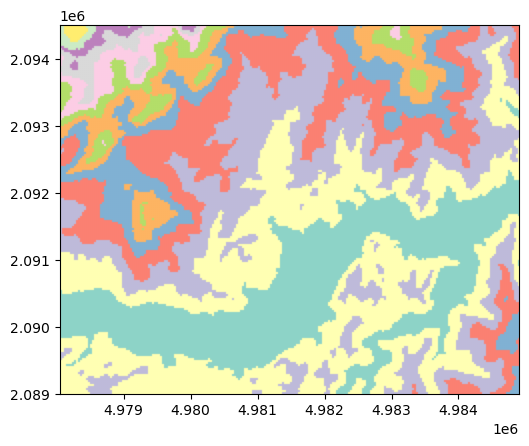

In [795]:
rasterio.plot.show(src, cmap='Set3');
rasterio.plot.show(dem_src_9377, cmap='Set3');